In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.linalg import toeplitz
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

In [2]:
# 환경설정
plt.style.use('classic')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [3]:
# 데이터 불러오기
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True
)
csv_path, _ = os.path.splitext(zip_path)

temp = pd.read_csv(csv_path)
temp['Date Time'] = temp['Date Time'].apply(lambda x: datetime.strptime(x, '%d.%m.%Y %H:%M:%S'))
temp = temp[['Date Time', 'T (degC)']]
temp.columns = ['datetime', 'temp']

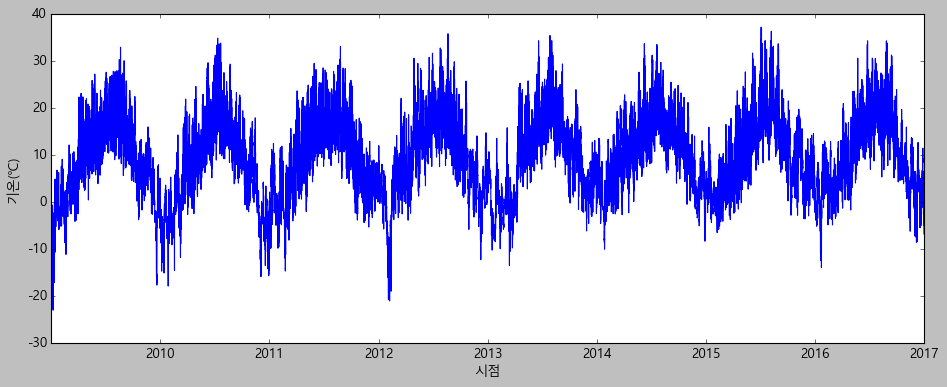

,count,mean,std,min,25%,50%,75%,max
temp,420551.0,9.450147,8.423365,-23.01,3.36,9.42,15.47,37.28


In [4]:
# 시각화
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(temp['datetime'], temp['temp'])
ax.set_xlabel('시점')
ax.set_ylabel('기온(℃)')
plt.tight_layout()
plt.show()

# 요약
temp_summary = temp.describe().T
temp_summary

In [68]:
# 데이터 설정
X_train = np.c_[temp['temp'], temp['temp'].shift(-1), temp['temp'].shift(-2)][:-3]
X_train = X_train[:,:,np.newaxis]
y_train = np.array(temp['temp'][3:])

m = int(X_train.shape[0]*0.75)
X_test, y_test = X_train[m:], y_train[m:]
X_train, y_train = X_train[:m], y_train[:m]

In [70]:
# 모델 설정
model = Sequential()
model.add(SimpleRNN(10, input_shape=(3,1)))
model.add(Dense(1, kernel_initializer='uniform', activation='linear'))
model.compile(loss='mse', optimizer='sgd')

In [ ]:
# 훈련
cp_callback = tf.keras.callbacks.ModelCheckpoint('cpts/cp.ckpt', save_weights_only=True, verbose=1)
result = model.fit(X_train, y_train,
                   epochs=5,
                   callbacks = [cp_callback],
                   verbose=0,
                   batch_size=None,
                   validation_data=(X_test, y_test))

In [87]:
# 검사
print(result.history['val_loss'])

[20.6491379118541, 18.85509084175315, 21.33856926932834, 19.60245526581457, 19.478641291461006]


In [56]:
# 모델 저장 및 불러오기
# model.save('models/my_model.h5')
# new_model = tf.keras.models.load_model('models/my_model.h5')

# 최근 체크포인트
# latest = tf.train.latest_checkpoint('cpts')

# 가중치 저장 및 불러오기
# model.save_weights('cpts/my_checkpoint')
# model.load_weights('cpts/my_checkpoint')

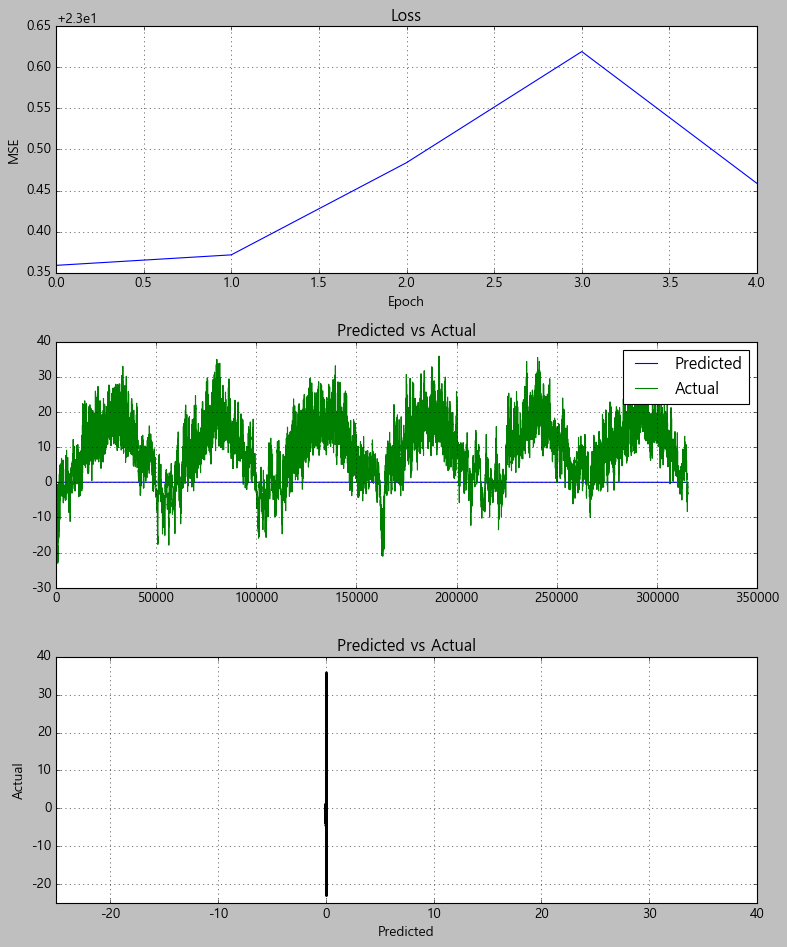

In [86]:
# 시각화
plt.figure(figsize=(10,12))

plt.subplot(311)
plt.plot(result.history['loss'])
plt.grid()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')

plt.subplot(312)
y_pred = model.predict(X_train)
y_actual = y_train.copy()
plt.plot(y_pred, '-', label='Predicted')
plt.plot(y_actual, '-', label='Actual')
plt.legend()
plt.grid()
plt.title('Predicted vs Actual')

plt.subplot(313)
plt.scatter(y_pred, y_actual, s=1)
plt.xlim(-25, 40)
plt.ylim(-25, 40)
plt.grid()
plt.title('Predicted vs Actual')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()